<a href="https://colab.research.google.com/github/ahmed-boutar/techniques-for-explainability/blob/main/techniques_for_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

rm: ./sample_data: No such file or directory


## Description

This notebook implements local explanation to the ResNet34 model predictions using LIME. By inputting a class label, the model will classify the image corresponding to the label. Then, we will use LIME to explain the prediction by plotting the superpixels that contribute to and against the prediction for the top 5 predictions.

Some of the code in this notebook was referenced from Phillip Lippe's notebook.<br> 

Source: https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb#scrollTo=y3loTwApmeNx

### Dataset and Model

We are using a pre-trained ResNet34 model provided by the torchvision package. This model was originally trained on the ImageNet dataset. For our explanation task, we're using a small, pre-processed subset of the ImageNet dataset, curated by Philippe Lippe and his team. This subset contains 5 images for each of the 1000 ImageNet labels, totaling 5000 images. This subset is shared under the same license as the original ImageNet dataset.

Standard Imports

In [3]:
## Standard libraries
import os
import json
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set_theme()
import random

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.utils.data as data
# Torchvision
import torchvision
from torchvision import transforms

# Import Skimage for segmentation
from skimage.segmentation import mark_boundaries

#Import pillow 
from PIL import Image

#Import LIME 
try:
    from lime import lime_image
except ModuleNotFoundError: # Google Colab does not have LIME installed by default. Hence, we do it here if necessary
    !pip install --quiet lime==0.2.0.1
    from lime import lime_image

#Import SHAP 
try:
    import shap
except ModuleNotFoundError: # Google Colab does not have SHAP installed by default. Hence, we do it here if necessary
    !pip install --quiet shap==0.45.1
    import shap

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
if torch.backends.mps.is_available():
    device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device", device)

Global seed set to 42


Using device cpu


Downloading the dataset

In [4]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])


We will use common CNN architectures trained on the ImageNet dataset. To be specific, we will use ResNet34, a pretrained model on the ImageNet dataset, provided by PyTorch's torchvision package. 

In [5]:
# Loading ResNet34 pretrained on ImageNet provided by torchvision
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Loading the dataset TinyImageNet we downloaded

In [6]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

### Using ResNet34 For Predictions

Let's first define a function that allows us to select an image based on the label we provide. Every label has 5 different images associated with it in the dataset. This function will randomly choose one of those images to use. 
Any label found in label_list.json can be used here (full path to the file: data/TinyImageNet/label_list.json)

In [7]:
def get_image_from_label(img_label):
    label_idx = get_label_index(img_label)
    img_specific_idx = random.randint(label_idx*5, label_idx*5 + 4)
    img_path = dataset.imgs[img_specific_idx][0]
    with open(os.path.abspath(img_path), 'rb') as f:
        with Image.open(f) as img:
            
            img = img.convert('RGB')
    return img

Provide an image label here, selected from the list of TinyImage labels found in under data/TinyImageNet/label_list.json

In [8]:
img_label = 'bulletproof vest'

In [9]:
img = get_image_from_label(img_label)

Let's visualize the image for the label we chose

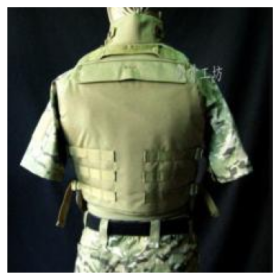

In [10]:
plt.imshow(img)
plt.axis('off') 
plt.show()

The function below plots an image along with a bar diagram of its predictions

In [11]:
def show_top_5_prediction(img, label):
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[get_label_index(label)])
    ax[0].axis('off')
    
    img_tensor = plain_transforms(img).unsqueeze(0)
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        pred = pretrained_model(img_tensor)
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    top5_vals, top5_idx = pred.topk(5, dim=-1)
    top5_vals, top5_idx = top5_vals.squeeze().cpu().numpy(), top5_idx.squeeze().cpu().numpy()
    ax[1].barh(
        np.arange(5), top5_vals*100.0, align='center',
        color=["C0" if top5_idx[i] != label else "C2" for i in range(5)]
    )
    ax[1].set_yticks(np.arange(5))
    ax[1].set_yticklabels([label_names[c] for c in top5_idx])
    ax[1].invert_yaxis()
    ax[1].set_xlabel('Confidence')
    ax[1].set_title('Predictions')
    
    plt.show()
    plt.close()

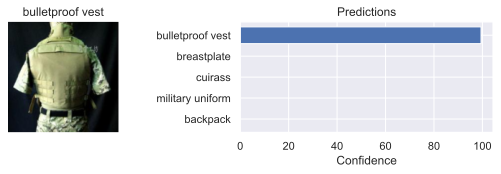

In [12]:
show_top_5_prediction(img, img_label)

### Explaining ResNet34 Using LIME

After classifying the selected image and seeing how the model performs, let's explain the prediction using LIME.

#### How Lime Works

1) LIME starts with the image we want to explain and the black-box model's prediction for that image. In our case, LIME would start with the image we retrieved earlier given the label we provided and ResNet34 prediction for that image (which is the label we provided)
2) The input image is segmented into interpretable components. In images, these are typically superpixels, clusters of pixels that share similar characteristics (e.g hue)
3) LIME creates multiple perturbed versions of the original image. It does this by randomly turning some superpixels on (keeping them as in the original image) and others off (usually replacing them with a solid color or noise).
4) The black-box model (in this case, ResNet34) makes predictions on all these perturbed images.
5) LIME uses an exponential smoothing kernel to assign weights to the perturbed samples based on their proximity to the original image. Samples that are more similar to the original image get higher weights. The Kernel Width is a variable that we can provide to determine the size of the neighborhood. 
6) LIME trains a simple, interpretable model (like a linear regression) on the perturbed samples. This model tries to approximate the black-box model's behavior in the local region around the original image.
7) The coefficients of this interpretable model represent the importance of each superpixel to the classification decision.
8) LIME selects the top features (superpixels) that have the highest positive impact on the predicted class. We can then visualize them by adding them as a mask to the image

### Why Lime

We want to provide local explanation to a black-box model's prediction. Choosing Lime is appropriate for the given reasons:
- Model Agnostic: LIME works with any black-box model, making it suitable for complex models like ResNet34.
- Local Explanations: It provides explanations for individual predictions, which is what we need here.
- Intuitive Visualizations Easy To Interpret: Since we are working with images, LIME is an appropriate choice as it highlights the regions that contribute most to the prediction, allowing us to plot them and visualizing them

### Explaining the prediction

Lime produces the array of images from original input image by pertubation algorithm. Let's define the classification function that would be used to classify the perturbed images and produce probabilities for each class.

Since the images in our dataset have been preprocessed, we won't need to resize or crop the image. However, we will still use the transformer defined previously to normalize the image. 

In [13]:
def classify_image(input): 
    img_tensor = torch.stack(tuple(plain_transforms(i) for i in input))
    pred = pretrained_model(img_tensor.to(device))
    pred = torch.softmax(pred, dim=-1)
    return pred.detach().cpu().numpy()

In [14]:
# Define kernel_width
kernel_width = 3
# Initialize LIME explainer; Here we are using the Image explainer since the instance 
# we're explaining is an image
explainer = lime_image.LimeImageExplainer(kernel_width=kernel_width)
# Explain the prediction using LIME
explanation = explainer.explain_instance(np.array(img), 
                                         classify_image, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) 

  0%|          | 0/3000 [00:00<?, ?it/s]

We will use the following function to plot the areas that contribute to and against the prediction

In [15]:
def show_explanation(img_1, mask_1, img_2, mask_2, label):
    # Plot on the left the image with explanations
    # On the right, have a image with the explaining area
    explained_img_1 = mark_boundaries(img_1 / 255.0, mask_1)
    hide_everything_but_explanation = mark_boundaries(img_2 / 255.0, mask_2)

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})
    
    # Left subplot: Image with explanations
    ax[0].imshow(explained_img_1)
    # Set the main title for the first subplot
    ax[0].set_title(f'Areas contributing to the "{label}" prediction', fontsize=12)
    # Turn off the grid and axis ticks
    ax[0].grid(False)
    ax[0].axis('off')

    # Right subplot: Image with only the explaining area
    ax[1].imshow(hide_everything_but_explanation)
    ax[1].set_title(f'Only the area explaining the "{label}" prediction', fontsize=12)
    ax[1].grid(False)
    ax[1].axis('off')
    
    # Add a centralized subtitle below the plots
    fig.text(0.5, -0.05, 'Areas in red contribute against the prediction. Areas in green contribute to the prediction', 
             ha='center', fontsize=10, color='gray')

    #show plot
    plt.show()
    plt.close()

Plotting explanations for the top 5 predictions of the selected image

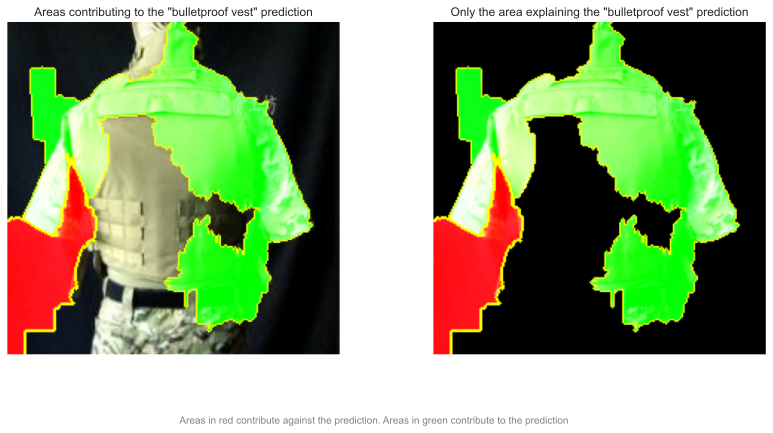

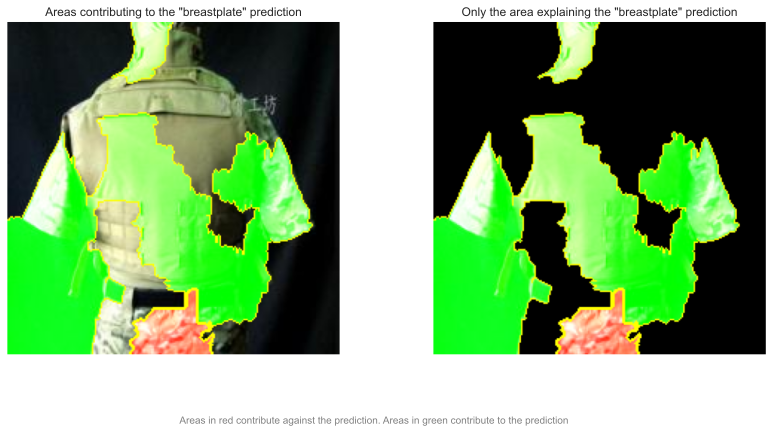

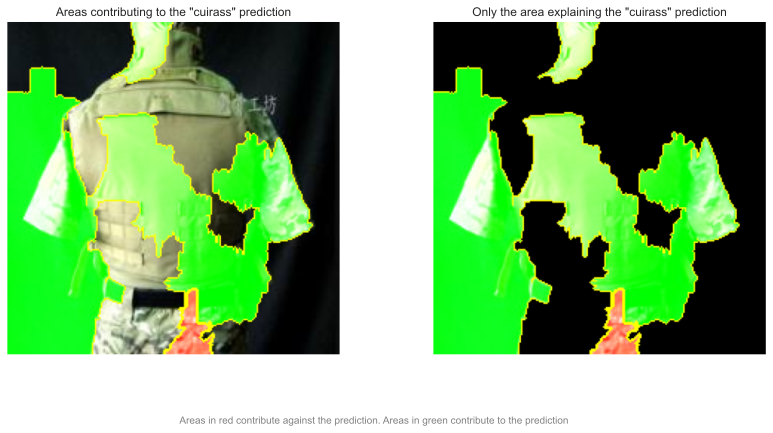

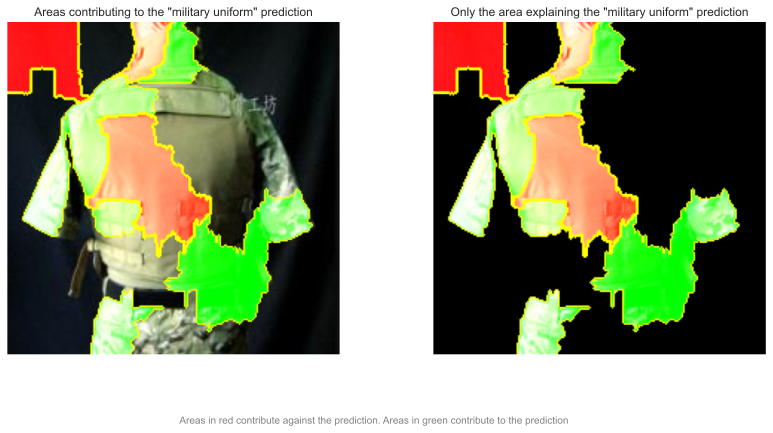

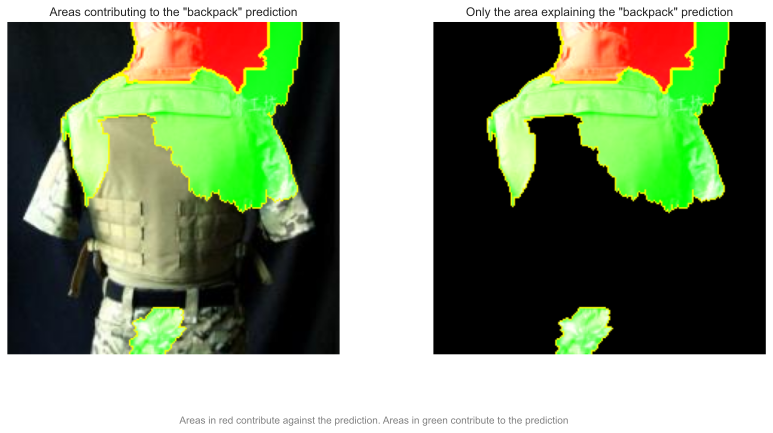

In [16]:
for i in range(5):
    img_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=False)
    img_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=True)
    show_explanation(img_1, mask_1, img_2, mask_2, label_names[explanation.top_labels[i]])


### Interpretation

On the left, the visualization shows the original image with highlighted regions corresponding to the superpixels contributing to the prediction. Green areas indicate regions that positively contribute to the model's prediction for the top class. The intensity of the color represents the strength of the contribution.

 We can see that the highlighted areas change based on the predicted label. It is interesting to note how different predictions have overlapping areas contributing to them. Some of the labels do not have a red area, representing the pixels contributing negatively (against) to the prediction, while others do. 

 On the right, the visualization shows only the regions contributing to the prediction, with the original image being masked. It is easier to see then how the general shape of the regions contributing to the predictions is very different from prediction to another, even though the regions may be overlapping.

### LIME Discussion

Strengths:

- LIME can provide intuitive visual explanations that are easily comprehensible to humans, its flexibility in application across various data types and models, and its local fidelity in accurately representing a model's behavior for specific instances.

Limitations:

- LIME's results can be sensitive to random perturbations, potentially leading to different explanations for the same image 
- Generating explanations can be slow, especially if we increase the number of samples or work on more complex models. 
- The quality of the explanations changes based on the hyperparameters used like the number of samples, the segmentation method, or the kernel's width
- There are no robust ways to find the Kernel's width optimally
- Recent research has shown that LIME can be fooled and exploited by hiding biases (e.g in the paper, they exploited the difference between the input data distribution and perturbations to create adversarial classifiers)

Potential Improvements: 

- Implementing an ensemble approach, where multiple explanations are generated and aggregated to decrease the instability of explanations
- Integrating LIME with other explanation techniques like SHAP could provide a more comprehensive explanation. 
- Change the perturbation strategy to also mimic the input data distribution 
- (Maybe) developing some metrics to evaluate the quality and stability of the explanations across different settings (could help provide a more objective explanation of local instances)

## Extra: GPT-2 Explained With SHAP

In [17]:
import shap
from transformers import GPT2LMHeadModel
from transformers import AutoTokenizer
import torch

# Load pre-trained model and tokenizer
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2", use_fast=True)
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
# set model decoder to true
model.config.is_decoder = True
model.config.task_specific_params['text_generation'] = {
    "do_sample": True,
    "no_repeat_ngram_size": 2,
}
    
# Set the pad token
tokenizer.pad_token = tokenizer.eos_token

s = ["Two Muslims"]
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(s)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [18]:
shap.plots.text(shap_values)

The input text is shown at the bottom, while the generated output is generated at the top of the plot. 
By hovering over words from the output, you can see what words contributed to the prediction of that word. The ones highlighted in pink contribute positively, while the ones highlighted in blue contribute negatively. 

It is interesting to notice the bias in GPT-2, where the first thing it generated about our given input of "Two Muslims" is a sentence about murde and attack. 

We can visualize what specific words contributed to the generation of the word killed specifically


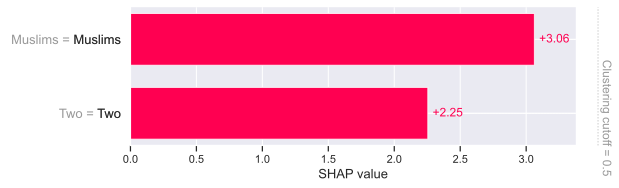

In [19]:
shap.plots.bar(shap_values[0, :, "killed"])

By defininig some specific inputs and outputs, we can also see how the model "associates" some words or expressions to each other. Here, our focus would be to understand the words that GPT-2 "thinks" could result in outputting "vodka"

In [20]:
# define input
x = [
    "I know many people who are Russian.",
    "I know many people who are Turkish.",
    "I know many people who are Australian.",
    "I know many people who are American.",
    "I know many people who are Italian.",
    "I know many people who are Spanish.",
    "I know many people who are German.",
    "I know many people who are Indian.",
]

In [21]:
# define output
y = [
    "They love their vodka!",
    "They love their vodka!",
    "They love their vodka!",
    "They love their vodka!",
    "They love their vodka!",
    "They love their vodka!",
    "They love their vodka!",
    "They love their vodka!",
]

In [22]:
teacher_forcing_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token="...", collapse_mask_token=True)

In [23]:
shap_values = explainer(x, y)

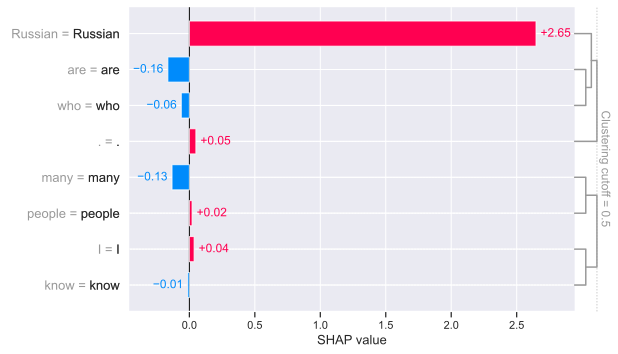

In [24]:
# We are plotting the first input here, which corresponds to I know many people who are Russian.
# Feel free to experiment with the other inputs as well 
shap.plots.bar(shap_values[0, :, "vodka"])

In [25]:
shap.plots.text(shap_values)